***Natural Language Processing with Disaster Tweets - NLP IL Mentoring Initiative***

This project was done as a part of a mentoring initiative by NLP IL.
We formed a group of 4 and worked on the Kaggle knowlage competition to create a classifier for disaster tweets, the compatition can be found here: https://www.kaggle.com/competitions/nlp-getting-started

**Imports**

In [1]:
import pandas as pd
import numpy as np
import re
from collections.abc import Mapping

import unicodedata

import collections.abc

collections.Mapping = collections.abc.Mapping
collections.MutableMapping = collections.abc.MutableMapping
collections.Iterable = collections.abc.Iterable
collections.MutableSet = collections.abc.MutableSet
collections.Callable = collections.abc.Callable

import spacy

from scipy.special import softmax
import csv
import urllib.request

import nltk

from tqdm.notebook import tqdm
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoModelForMaskedLM
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

AttributeError: module 'tensorflow.security.fuzzing.py.annotation_types' has no attribute 'Float8e4m3fn'

In [ ]:
#loading data, removing labels from df

data = pd.read_csv(r"C:\Users\rotem\Desktop\job\nlp-getting-started\train.csv")
y = data['target']
data = data.drop(columns=['target'])

**Preprocessing**

We decided to create a few new features for our classifier to help with the prediction. Our data contains 3 columns: keywords, location and text. We added a feature to mark if the location mentioned is a real plae or not, if the text contains hashtags and if the text contains urls. We also added sentiment analysis of the text as a featue (positive, negative or neutral). We used both TextBlob and RoBERTa for the sentiment analysis to see if there are any inconsistencies.

In [ ]:
#remove accents from str

def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [ ]:
# tokenization and embedding using BERT (bertweets)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

bertweet = AutoModel.from_pretrained("vinai/bertweet-base").to(device)

# For transformers v4.x+:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

tqdm.pandas()

def feature_extract(line):
    input_ids = torch.tensor([tokenizer.encode(line)]).to(device)

    with torch.no_grad():
        features = bertweet(input_ids)  # Models outputs are now tuples
    return np.array(features[1].cpu()).flatten()

In [ ]:
#sentiment analysis using textblob

def sentiment_analysis(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity

    if polarity > 0: #possitive
        sentiment = 0
    
    elif polarity < 0: #negative
        sentiment = 1
    
    else: #neutral
        sentiment = 2
    
    return sentiment

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"


tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")
model = AutoModelForMaskedLM.from_pretrained("cardiffnlp/twitter-roberta-base")

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

def sentiment(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    final_label = 0
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        #The first score is the largest
        if l == 'neutral':
          final_label = 2
        elif l == 'positive':
          final_label = 0
        else:
          final_label = 1
        return final_label

In [ ]:
#loading an nlp model to remove stopwords

nlp = spacy.load('en_core_web_sm')

nltk.download('stopwords')

stopword_list = nltk.corpus.stopwords.words('english')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

C:\Users\rotem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rotem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# In this preprocessing function we created new features for the classifier, and converted the textual data to vectors using a BERT model

def preprocessing_func(dataframe):
    dataframe['location_str'] = dataframe['location'].apply(str)
    dataframe['location_str'] = dataframe['location_str'].apply(strip_accents)
    dataframe['ents'] = dataframe['location_str'].apply(lambda x: [ent.label_ for ent in nlp(x).ents])
    dataframe['is_real_location'] = dataframe['ents'].apply(lambda x: 1 if 'GPE' in x else 0)
    dataframe['contains_hashtags'] = dataframe['text'].apply(lambda x: 1 if '#' in x else 0)
    dataframe['contains_url'] = dataframe['text'].apply(lambda x: 1 if re.search('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x) else 0)
    dataframe['urls'] = dataframe['text'].apply(lambda x: re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x))
    dataframe['urls'] = dataframe['urls'].apply(lambda x: "".join(x))
    dataframe['transformer_sentiment'] = dataframe['text'].apply(sentiment)
    dataframe['textblob_sentiment'] = dataframe['text'].apply(lambda x: sentiment_analysis(x))
    dataframe['keyword_str'] = dataframe['keyword'].apply(str)
    dataframe['text'] = dataframe['text'].apply(lambda x: x.lower())

    dataframe['BERT_text'] = dataframe.apply(lambda row: feature_extract(row['text']), axis=1)
    dataframe['BERT_location'] = dataframe.apply(lambda row: feature_extract(row['location_str']), axis=1)
    dataframe['BERT_keyword'] = dataframe.apply(lambda row: feature_extract(row['keyword_str']), axis=1)
    dataframe['BERT_urls'] = dataframe.apply(lambda row: feature_extract(row['urls']), axis=1)

    dataframe = dataframe[['text', 'is_real_location', 'contains_hashtags', 'contains_url', 'textblob_sentiment', 'transformer_sentiment', 'BERT_text', 'BERT_location',
                           'BERT_keyword', 'BERT_urls']]
    dataframe.fillna(0, inplace=True)


    return dataframe

In [ ]:
x = preprocessing_func(data)
x_copy = x.copy() #backup

x

C:\Users\rotem\AppData\Local\Temp\ipykernel_10476\952843720.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.fillna(0, inplace=True)


,text,is_real_location,contains_hashtags,contains_url,textblob_sentiment,transformer_sentiment,BERT_text,BERT_location,BERT_keyword,BERT_urls
0,our deeds are the reason of this #earthquake m...,0,1,0,2,2,"[0.2065064, -0.18074755, 0.02663709, -0.205899...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24817608, -0.19967185, 0.06432723, -0.20642..."
1,forest fire near la ronge sask. canada,0,0,0,0,2,"[0.22811998, -0.22426017, 0.048476256, -0.1352...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24817608, -0.19967185, 0.06432723, -0.20642..."
2,all residents asked to 'shelter in place' are ...,0,0,0,1,2,"[0.16213681, -0.14271349, 0.042422224, -0.1531...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24817608, -0.19967185, 0.06432723, -0.20642..."
3,"13,000 people receive #wildfires evacuation or...",0,1,0,2,2,"[0.23523901, -0.19116087, 0.027794741, -0.0934...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24817608, -0.19967185, 0.06432723, -0.20642..."
4,just got sent this photo from ruby #alaska as ...,0,1,0,2,1,"[0.16015676, -0.17771426, -0.015724916, -0.242...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24817608, -0.19967185, 0.06432723, -0.20642..."
...,...,...,...,...,...,...,...,...,...,...
7608,two giant cranes holding a bridge collapse int...,0,0,1,2,2,"[0.157583, -0.19802022, 0.06450198, -0.1095030...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.21396138, -0.20185995, 0.059142746, -0.1491..."
7609,@aria_ahrary @thetawniest the out of control w...,0,0,0,0,1,"[0.25083506, -0.12898737, 0.05149367, -0.09911...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24817608, -0.19967185, 0.06432723, -0.20642..."
7610,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,0,0,1,2,2,"[0.183044, -0.16800967, 0.0017931348, -0.21252...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.1937009, -0.14825259, 0.024173358, -0.22655..."
7611,police investigating after an e-bike collided ...,0,0,0,1,1,"[0.114002645, -0.24617758, 0.08301947, -0.2254...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24129638, -0.17712024, 0.07973514, -0.22637...","[0.24817608, -0.19967185, 0.06432723, -0.20642..."


We decided to use TF-IDF vectorization to try and get some more information.

In [ ]:
v = TfidfVectorizer()

vecs = v.fit_transform(x['text']).toarray()

We cannot feed an array to the basic classification models, so we used SVD to get the most important feature from our arrays and used it in our models.

In [ ]:
svd = TruncatedSVD(n_components=1)
pack = svd.fit_transform(vecs)

BERT_txt = x['BERT_text'].tolist()
BERT_txt = svd.fit_transform(BERT_txt)

BERT_loc = x['BERT_location'].tolist()
BERT_loc = svd.fit_transform(BERT_loc)

BERT_kw = x['BERT_keyword'].tolist()
BERT_kw = svd.fit_transform(BERT_kw)

BERT_url = x['BERT_urls'].tolist()
BERT_url = svd.fit_transform(BERT_url)


In [ ]:
x['processed_text'] = pack.tolist()
x['BERT_text'] = BERT_txt.tolist()
x['BERT_location'] = BERT_loc.tolist()
x['BERT_keyword'] = BERT_kw.tolist()
x['BERT_urls'] = BERT_url.tolist()
x.drop(columns=['text'], inplace=True)

x['processed_text'] = x['processed_text'].apply(lambda x: x.pop())
x['BERT_text'] = x['BERT_text'].apply(lambda x: x.pop())
x['BERT_location'] = x['BERT_location'].apply(lambda x: x.pop())
x['BERT_keyword'] = x['BERT_keyword'].apply(lambda x: x.pop())
x['BERT_urls'] = x['BERT_urls'].apply(lambda x: x.pop())

C:\Users\rotem\AppData\Local\Temp\ipykernel_10476\452538994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['processed_text'] = pack.tolist()
C:\Users\rotem\AppData\Local\Temp\ipykernel_10476\452538994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['BERT_text'] = BERT_txt.tolist()
C:\Users\rotem\AppData\Local\Temp\ipykernel_10476\452538994.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

**Building Models**

In [ ]:
test = 0.2
seed = 42

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test, random_state=seed)

**XGBoost**

In [ ]:
xgboost_model = XGBClassifier()

params = {'eta': [0.2, 0.3, 0.4, 0.5, 0.6], 'gamma': list(range(0,5)),'lambda': [0, 0.5, 1, 1.5, 2], 'alpha': [0, 0.5, 1, 1.5, 2]}

find_xg_model = GridSearchCV(xgboost_model, params, scoring='roc_auc', error_score='raise')
find_xg_model.fit(x_train, y_train)

best_xg_params = find_xg_model.best_params_
best_xg_params


{'alpha': 0.5, 'eta': 0.2, 'gamma': 0, 'lambda': 1}

In [ ]:
best_xgboost_model = XGBClassifier(**best_xg_params, random_state = seed)
best_xgboost_model.fit(x_train, y_train)

XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [ ]:
xgb_pred = best_xgboost_model.predict(x_val)

In [ ]:
acc = accuracy_score(y_val, xgb_pred)
print(classification_report(y_val, xgb_pred))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       874
           1       0.72      0.62      0.67       649

    accuracy                           0.74      1523
   macro avg       0.73      0.72      0.72      1523
weighted avg       0.73      0.74      0.73      1523



In [ ]:
x_features_train_full = x[['is_real_location', 'contains_hashtags', 'contains_url', 'textblob_sentiment', 'transformer_sentiment']]

x_features_train_full

,is_real_location,contains_hashtags,contains_url,textblob_sentiment,transformer_sentiment
0,0,1,0,2,2
1,0,0,0,0,2
2,0,0,0,1,2
3,0,1,0,2,2
4,0,1,0,2,1
...,...,...,...,...,...
7608,0,0,1,2,2
7609,0,0,0,0,1
7610,0,0,1,2,2
7611,0,0,0,1,1


In [ ]:
x_features_train, x_features_val, y_features_train, y_features_val = train_test_split(x_features_train_full, y, test_size=test, random_state=seed)

In [ ]:
find_xg_feat_model = GridSearchCV(xgboost_model, params, scoring='roc_auc', error_score='raise')
find_xg_feat_model.fit(x_features_train, y_features_train)

best_xg_feat_params = find_xg_feat_model.best_params_


In [ ]:
best_xgboost_feat_model = XGBClassifier(**best_xg_feat_params, random_state = seed)
best_xgboost_feat_model.fit(x_features_train, y_features_train)

feat_val = best_xgboost_feat_model.predict(x_features_val)

acc = accuracy_score(y_features_val, feat_val)
print(classification_report(y_features_val, feat_val))

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       874
           1       0.63      0.56      0.59       649

    accuracy                           0.67      1523
   macro avg       0.66      0.65      0.66      1523
weighted avg       0.67      0.67      0.67      1523



In [ ]:
x_BERT = x[['BERT_text', 'BERT_location', 'BERT_keyword', 'BERT_urls', 'processed_text']]
x_BERT_train, x_BERT_val, y_BERT_train, y_BERT_val = train_test_split(x_features_train_full, y, test_size=test, random_state=seed)

In [ ]:
find_xg_BERT_model = GridSearchCV(xgboost_model, params, scoring='roc_auc', error_score='raise')
find_xg_BERT_model.fit(x_BERT_train, y_BERT_train)

best_xg_BERT_params = find_xg_BERT_model.best_params_

best_xgboost_BERT_model = XGBClassifier(**best_xg_BERT_params, random_state = seed)
best_xgboost_BERT_model.fit(x_BERT_train, y_BERT_train)

BERT_val = best_xgboost_BERT_model.predict(x_BERT_val)

acc = accuracy_score(y_BERT_val, BERT_val)
print(classification_report(y_BERT_val, BERT_val))

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       874
           1       0.63      0.56      0.59       649

    accuracy                           0.67      1523
   macro avg       0.66      0.65      0.66      1523
weighted avg       0.67      0.67      0.67      1523



**SVM**

Gridseach took too long, so we did it manually step-by-step - there is no need to run all of the code therefore it is left as a comment for documentation.

In [ ]:
'''
# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1, class_weight={1: 0.9})
svm_classifier.fit(x_train, y_train)

# Make predictions and evaluate the classifier
svm_pred = svm_classifier.predict(x_val)
print(classification_report(y_val, svm_pred))
'''

"\n# Initialize and train the SVM classifier\nsvm_classifier = SVC(kernel='rbf', C=1, class_weight={1: 0.9})\nsvm_classifier.fit(x_train, y_train)\n\n# Make predictions and evaluate the classifier\nsvm_pred = svm_classifier.predict(x_val)\nprint(classification_report(y_val, svm_pred))\n"

In [ ]:
'''
# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='poly', C=1, class_weight={1: 0.9})
svm_classifier.fit(x_train, y_train)

# Make predictions and evaluate the classifier
svm_pred = svm_classifier.predict(x_val)
print(classification_report(y_val, svm_pred))
'''

"\n# Initialize and train the SVM classifier\nsvm_classifier = SVC(kernel='poly', C=1, class_weight={1: 0.9})\nsvm_classifier.fit(x_train, y_train)\n\n# Make predictions and evaluate the classifier\nsvm_pred = svm_classifier.predict(x_val)\nprint(classification_report(y_val, svm_pred))\n"

In [ ]:
'''
# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1, class_weight={1: 0.9})
svm_classifier.fit(x_train, y_train)

# Make predictions and evaluate the classifier
svm_pred = svm_classifier.predict(x_val)
print(classification_report(y_val, svm_pred))
'''

"\n# Initialize and train the SVM classifier\nsvm_classifier = SVC(kernel='linear', C=1, class_weight={1: 0.9})\nsvm_classifier.fit(x_train, y_train)\n\n# Make predictions and evaluate the classifier\nsvm_pred = svm_classifier.predict(x_val)\nprint(classification_report(y_val, svm_pred))\n"

In [ ]:
'''
svm_model = SVC()

params = {'C': [0.2, 0.5, 1, 1.5, 2, 2.5, 3], 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}

find_svn_model = GridSearchCV(svm_model, params, scoring='roc_auc', error_score='raise')
find_svn_model.fit(x_train, y_train)

best_svm_params = find_svn_model.best_params_
best_svm_params
'''

"\nsvm_model = SVC()\n\nparams = {'C': [0.2, 0.5, 1, 1.5, 2, 2.5, 3], 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}\n\nfind_svn_model = GridSearchCV(svm_model, params, scoring='roc_auc', error_score='raise')\nfind_svn_model.fit(x_train, y_train)\n\nbest_svm_params = find_svn_model.best_params_\nbest_svm_params\n"

In [ ]:
'''
params = {'C': [3, 3.5, 4, 4.5, 5, 5.5, 6]}

svm_model = SVC(kernel='poly')

find_svn_model = GridSearchCV(svm_model, params, scoring='roc_auc', error_score='raise')
find_svn_model.fit(x_train, y_train)

best_svm_params = find_svn_model.best_params_
best_svm_params
'''

"\nparams = {'C': [3, 3.5, 4, 4.5, 5, 5.5, 6]}\n\nsvm_model = SVC(kernel='poly')\n\nfind_svn_model = GridSearchCV(svm_model, params, scoring='roc_auc', error_score='raise')\nfind_svn_model.fit(x_train, y_train)\n\nbest_svm_params = find_svn_model.best_params_\nbest_svm_params\n"

In [ ]:
'''
params = {'degree': list(range(1, 6))}

svm_model = SVC(kernel='poly', C=6, gamma='auto')

find_svn_model = GridSearchCV(svm_model, params, scoring='roc_auc', error_score='raise')
find_svn_model.fit(x_train, y_train)

best_svm_params = find_svn_model.best_params_
best_svm_params
'''

"\nparams = {'degree': list(range(1, 6))}\n\nsvm_model = SVC(kernel='poly', C=6, gamma='auto')\n\nfind_svn_model = GridSearchCV(svm_model, params, scoring='roc_auc', error_score='raise')\nfind_svn_model.fit(x_train, y_train)\n\nbest_svm_params = find_svn_model.best_params_\nbest_svm_params\n"

In [ ]:
best_svm_model = SVC(kernel='poly', C=6, degree= 5, random_state = seed)
best_svm_model.fit(x_train, y_train)

SVC(C=6, degree=5, kernel='poly', random_state=42)

In [ ]:
# Make predictions and evaluate the classifier
svm_pred = best_svm_model.predict(x_val)
print(classification_report(y_val, svm_pred))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       874
           1       0.62      0.55      0.59       649

    accuracy                           0.67      1523
   macro avg       0.66      0.65      0.66      1523
weighted avg       0.67      0.67      0.67      1523



**Fully Connected Neural Network**

Build a simple NN to compare to the linear models.

In [ ]:
# Define the CNN architecture
cnn_model = Sequential([
    Dense(128, activation='relu', input_shape=x_train.shape[1:]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
cnn_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
191/191 [==============================] - 1s 2ms/step - loss: 0.6677 - accuracy: 0.5906 - val_loss: 0.6549 - val_accuracy: 0.5732
Epoch 2/10
191/191 [==============================] - 0s 2ms/step - loss: 0.6481 - accuracy: 0.6250 - val_loss: 0.6396 - val_accuracy: 0.6507
Epoch 3/10
191/191 [==============================] - 0s 2ms/step - loss: 0.6430 - accuracy: 0.6365 - val_loss: 0.6370 - val_accuracy: 0.6527
Epoch 4/10
191/191 [==============================] - 0s 2ms/step - loss: 0.6310 - accuracy: 0.6507 - val_loss: 0.6177 - val_accuracy: 0.6756
Epoch 5/10
191/191 [==============================] - 0s 2ms/step - loss: 0.6247 - accuracy: 0.6547 - val_loss: 0.6131 - val_accuracy: 0.6684
Epoch 6/10
191/191 [==============================] - 0s 2ms/step - loss: 0.6230 - accuracy: 0.6525 - val_loss: 0.6111 - val_accuracy: 0.6678
Epoch 7/10
191/191 [==============================] - 0s 2ms/step - loss: 0.6224 - accuracy: 0.6530 - val_loss: 0.6169 - val_accuracy: 0.6513
Epoch 

In [ ]:
cnn_pred = cnn_model.predict(x_val)
cnn_pred=np.argmax(cnn_pred,axis=1)

48/48 [==============================] - 0s 1ms/step


**LLM**

Used ChatGPT to train an LLM for this classification. We never worked with LLMs before, and a lot of the formates we found online didn't fit our data - so ChatGPT helped find something that fits.

In [ ]:
x_llm_train = pd.concat([data['text'], y], axis=1)

x_llm_train

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @thetawniest the out of control w...,1
7610,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1
7611,police investigating after an e-bike collided ...,1


In [ ]:
# Split dataset into train and test sets
train_df, test_df = train_test_split(x_llm_train, test_size=test, random_state=seed)

# Define dataset class
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)  # Change num_labels according to your task

# Define training parameters
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create DataLoader for training and testing
train_dataset = MyDataset(train_df['text'].values, train_df['target'].values, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MyDataset(test_df['text'].values, test_df['target'].values, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
model.train()
for epoch in range(3):  # adjust the number of epochs as needed
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

predictions = []
accuracy = 0

# Evaluation loop
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predictions.append(predicted.indices)
        
    accuracy = total_correct / total_samples
    print(f'Accuracy: {accuracy}')

C:\Users\rotem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Accuracy: 0.8292843072882469


In [ ]:
predictions = []
true_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

**Visualizations**

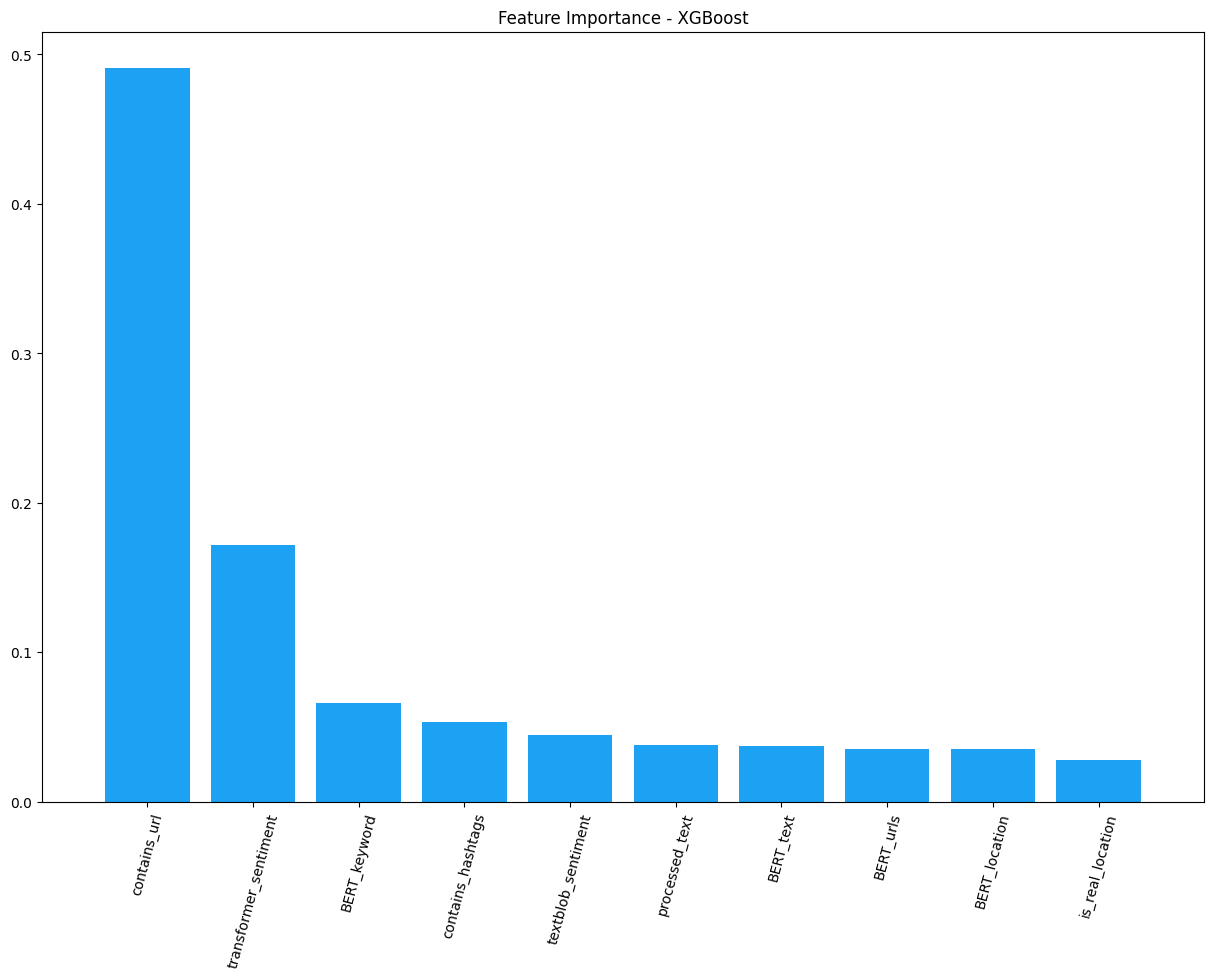

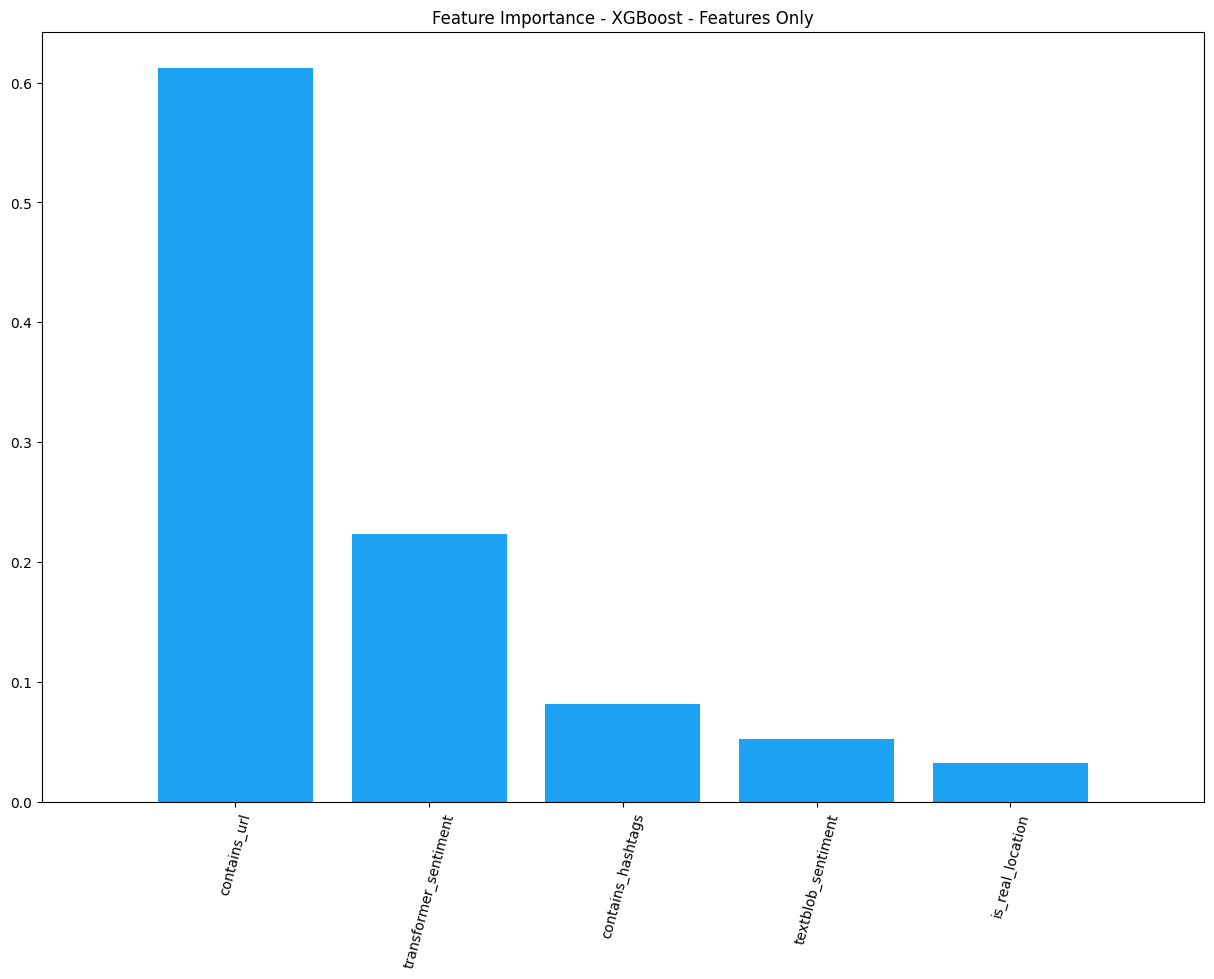

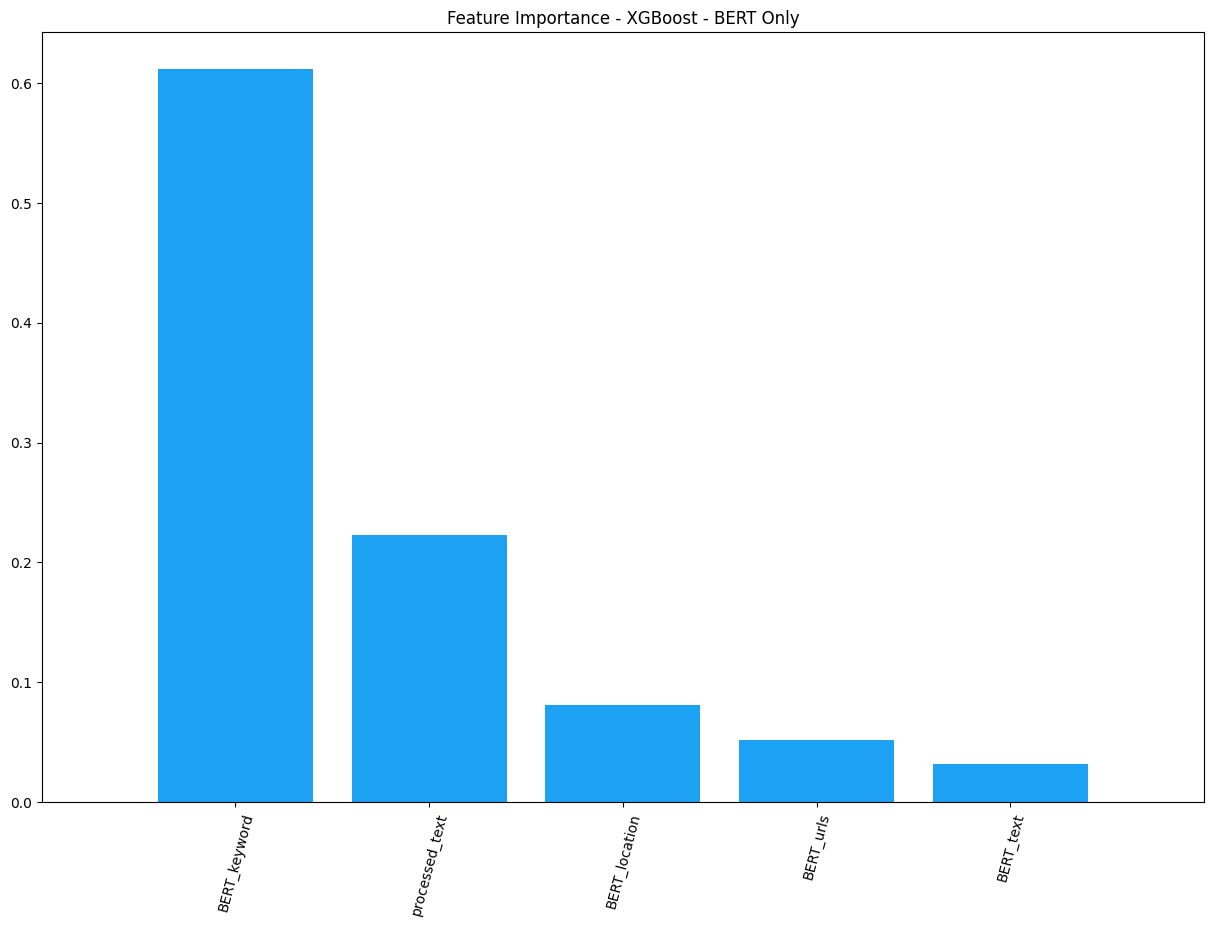

In [ ]:
def plot_feature_importence(model, data, model_name):
       feats = model.feature_importances_
       idx = np.argsort(feats)[::-1]
       cols_names = data.columns

       #plot
       plt.figure(figsize=(15, 10))
       plt.title('Feature Importance - ' + model_name)
       plt.bar(range(data.shape[1]), feats[idx],
              color="#1da1f2", align="center")
       plt.xticks(range(data.shape[1]), cols_names[idx], rotation= 75)
       plt.xlim([-1, data.shape[1]])
       plt.show()

plot_feature_importence(best_xgboost_model, x_train, 'XGBoost')
plot_feature_importence(best_xgboost_feat_model, x_features_train, 'XGBoost - Features Only')
plot_feature_importence(best_xgboost_BERT_model, x_BERT, 'XGBoost - BERT Only')

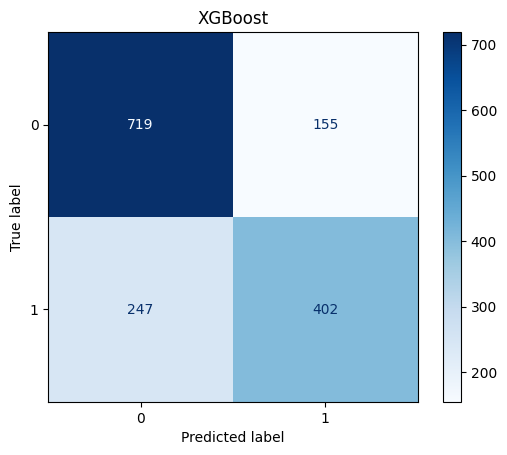

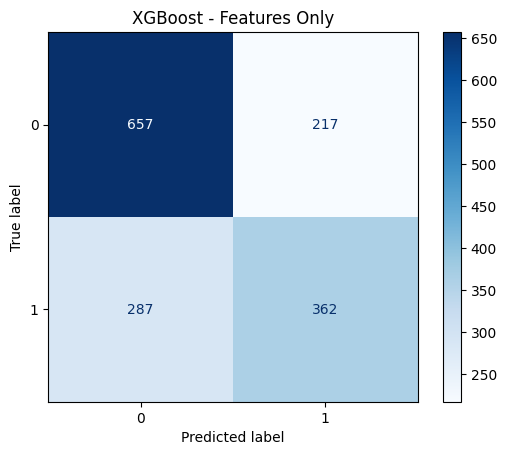

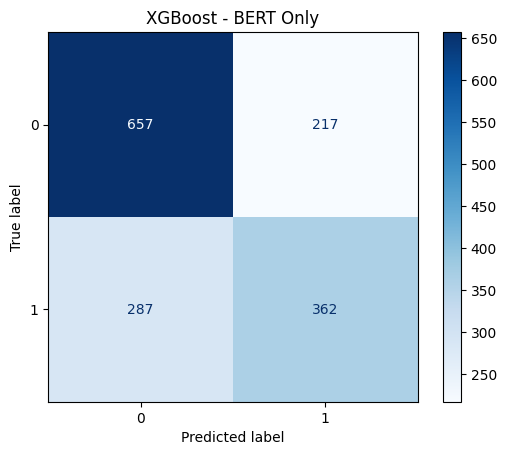

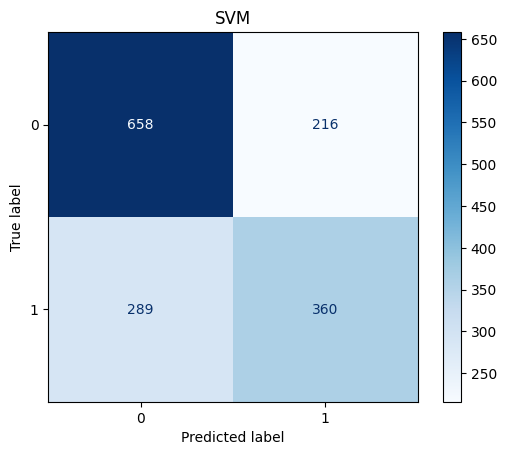

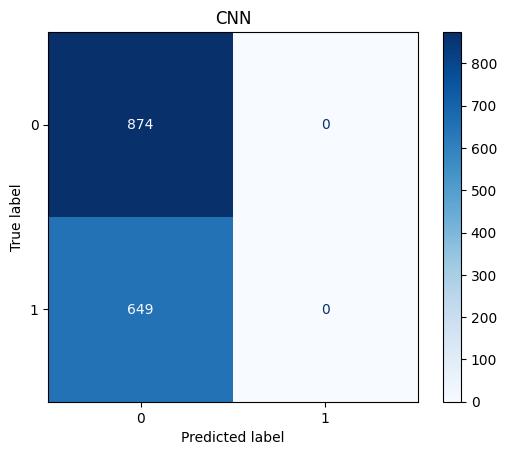

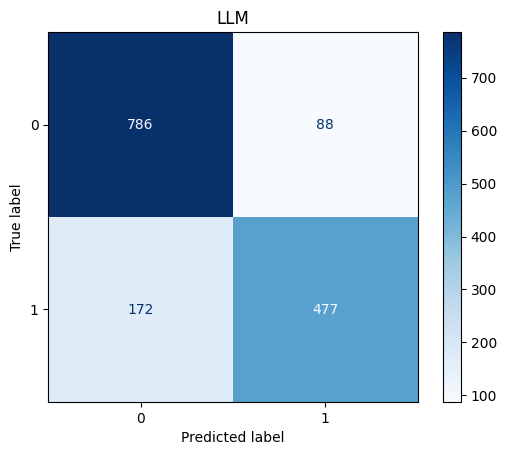

In [ ]:
models_dict = {'XGBoost': (y_val, xgb_pred), 'XGBoost - Features Only': (y_features_val, feat_val),
               'XGBoost - BERT Only': (y_BERT_val, BERT_val), 'SVM': (y_val, svm_pred), 'NN': (y_val, cnn_pred), 'LLM' :(test_df['target'], predictions)}

for key in models_dict:
    disp = ConfusionMatrixDisplay.from_predictions(models_dict[key][0],models_dict[key][1], cmap=plt.cm.Blues)
    disp.ax_.set_title(key)

In [ ]:
#plot accuracy of all models

accuracy_scores = []

for key in models_dict:
    accuracy_scores.append((key, accuracy_score(models_dict[key][1],models_dict[key][0])))

accuracy_scores.sort(key=lambda x: x[1], reverse=True)

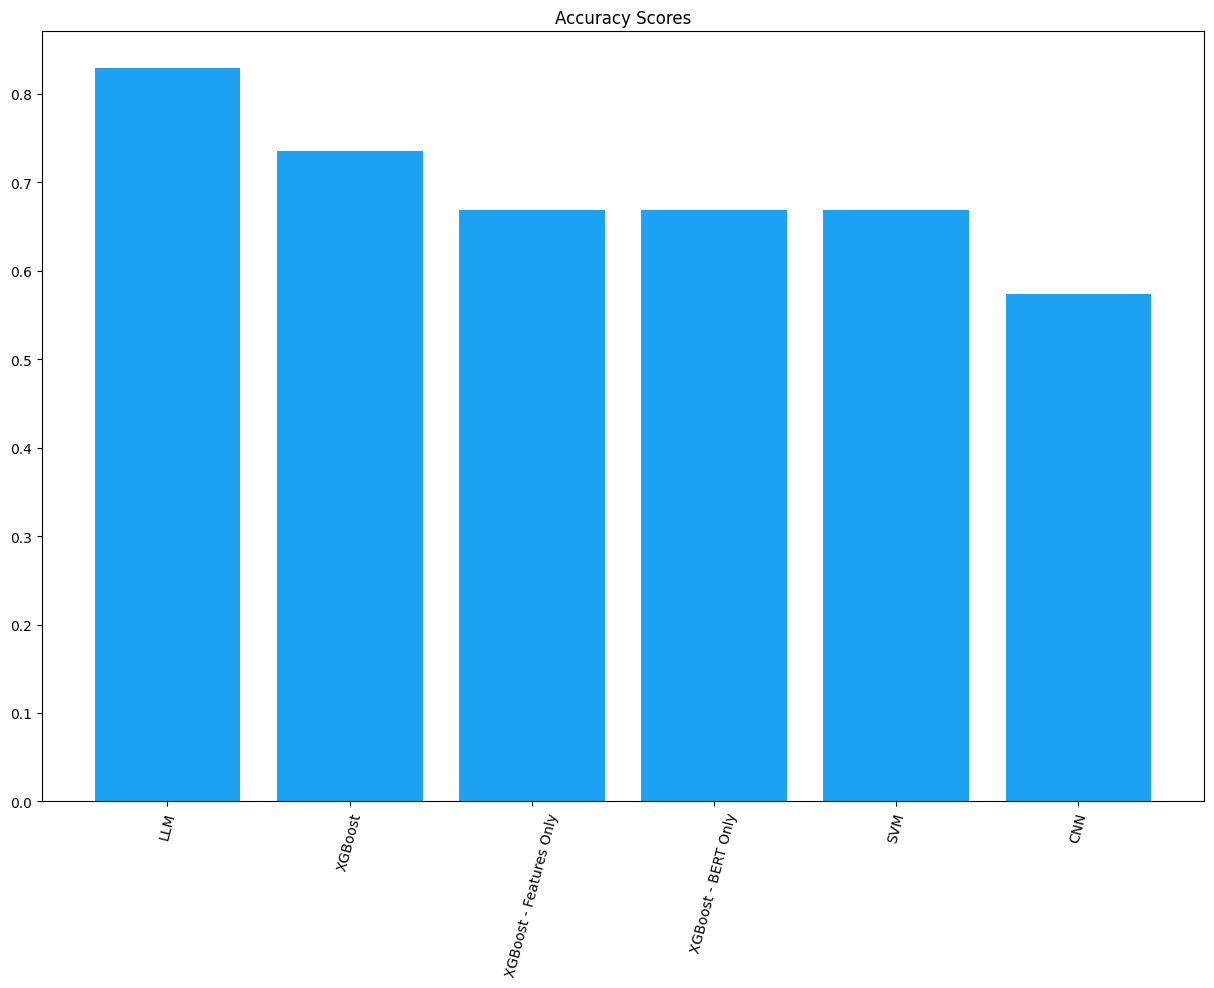

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(range(len(accuracy_scores)), [val[1] for val in accuracy_scores], align='center', color="#1da1f2")
plt.xticks(range(len(accuracy_scores)), [val[0] for val in accuracy_scores])
plt.xticks(rotation=75)
plt.title('Accuracy Scores')
plt.show()